# Transformer翻译项目

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#一.-建立Transformer模型的直观认识" data-toc-modified-id="一.-建立Transformer模型的直观认识-1">一. 建立Transformer模型的直观认识</a></span></li><li><span><a href="#二.-编码器部分（Encoder）" data-toc-modified-id="二.-编码器部分（Encoder）-2">二. 编码器部分（Encoder）</a></span><ul class="toc-item"><li><span><a href="#0.-先准备好输入的数据" data-toc-modified-id="0.-先准备好输入的数据-2.1">0. 先准备好输入的数据</a></span></li><li><span><a href="#1.-positional-encoding（即位置嵌入或位置编码）" data-toc-modified-id="1.-positional-encoding（即位置嵌入或位置编码）-2.2">1. positional encoding（即位置嵌入或位置编码）</a></span></li><li><span><a href="#2.-self-attention（自注意力机制）" data-toc-modified-id="2.-self-attention（自注意力机制）-2.3">2. self attention（自注意力机制）</a></span></li><li><span><a href="#3.-Attention-Mask" data-toc-modified-id="3.-Attention-Mask-2.4">3. Attention Mask</a></span></li><li><span><a href="#4.-Layer-Normalization-和残差连接" data-toc-modified-id="4.-Layer-Normalization-和残差连接-2.5">4. Layer Normalization 和残差连接</a></span></li><li><span><a href="#5.-Transformer-Encoder-整体结构" data-toc-modified-id="5.-Transformer-Encoder-整体结构-2.6">5. Transformer Encoder 整体结构</a></span></li></ul></li><li><span><a href="#三.-解码器部分（Decoder）" data-toc-modified-id="三.-解码器部分（Decoder）-3">三. 解码器部分（Decoder）</a></span></li><li><span><a href="#四.-Transformer模型" data-toc-modified-id="四.-Transformer模型-4">四. Transformer模型</a></span></li><li><span><a href="#五.-模型训练" data-toc-modified-id="五.-模型训练-5">五. 模型训练</a></span></li><li><span><a href="#六.-模型预测" data-toc-modified-id="六.-模型预测-6">六. 模型预测</a></span></li></ul></div>

在这份notebook当中，我们会(尽可能)实现 $Transformer$ 模型来完成翻译任务。  
（参考论文：$Attention\; Is\; All\; You\; Need$   https://arxiv.org/pdf/1706.03762.pdf ）

我们的数据集非常小，只有一万多个句子的训练数据，从结果来看训练出来的模型在测试集上的表现其实已经算还可以了。  
如果想得到更好的效果，则需要更大的数据量并进行更多的训练迭代次数，感兴趣（并且有硬件条件）的同学可以进行尝试。  

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


In [1]:
%%html
<img src="./imgs/rnn1.jpeg", width=660>
<img src="./imgs/rnn_att.jpeg", width=660>

## 一. 建立Transformer模型的直观认识
  
首先来说一下**Transformer**和**LSTM**的最大区别，就是LSTM的训练是迭代（自回归）的，是一个接一个字的来，当前这个字过完LSTM单元，才可以进下一个字，而 $Transformer$ 的训练是并行了，就是所有字是全部同时训练的，这样就大大加快了计算效率，$Transformer$ 使用了位置嵌入$(positional \ encoding)$来理解语言的顺序，使用自注意力机制和全连接层来进行计算，这些后面都会详细讲解。   
  
$Transformer$ 模型主要分为**两大部分**，分别是**编码器（$Encoder$）**和**解码器（$Decoder$）**：  
- **编码器（$Encoder$）**负责把自然语言序列映射成为**隐藏层**(下图中**第2步**用九宫格比喻的部分)，含有自然语言序列的数学表达
- **解码器（$Decoder$）**再把隐藏层映射为自然语言序列，从而使我们可以解决各种问题，如情感分类、命名实体识别、语义关系抽取、摘要生成、机器翻译等等。




In [2]:
%%html

<img src="./imgs/intuition.jpg", width=660>
<img src="./imgs/transformer.png", width=660>


## 二. 编码器部分（Encoder）
  
  
我们会**重点介绍编码器的结构**，因为理解了编码器中的结构, 理解解码器就非常简单了。而且我们用编码器就能够完成一些自然语言处理中比较主流的任务, 如情感分类, 语义关系分析, 命名实体识别等。  
  
**编码器（$Encoder$）**部分, 即把**自然语言序列映射为隐藏层的数学表达的过程**。  

**以下为一个Transformer Encoder Block结构示意图**
> 注意: 为方便查看, 下面各部分的内容分别对应着图中第1, 2, 3, 4个方框的序号：


<img src="encoder.jpg", width=550>


注意transformer向量维度的变化：

**输入向量维度： [batch_size, seq_len, embedding_size]**

**输出向量维度：[batch_size, seq_len, embedding_size]**

### 0. 先准备好输入的数据

In [5]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable

In [6]:
# 初始化参数设置
UNK = 0  # 未登录词的标识符对应的词典id
PAD = 1  # padding占位符对应的词典id
BATCH_SIZE = 64  # 每批次训练数据数量
EPOCHS = 20  # 训练轮数
LAYERS = 6  # transformer中堆叠的encoder和decoder block层数
H_NUM = 8  # multihead attention hidden个数
D_MODEL = 256  # embedding维数
D_FF = 1024  # feed forward第一个全连接层维数
DROPOUT = 0.1  # dropout比例
MAX_LENGTH = 60  # 最大句子长度

TRAIN_FILE = 'nmt/en-cn/train.txt'  # 训练集数据文件
DEV_FILE = "nmt/en-cn/dev.txt"  # 验证(开发)集数据文件
SAVE_FILE = 'save/model.pt'  # 模型保存路径(注意如当前目录无save文件夹需要自己创建)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def seq_padding(X, padding=0):
    """
    对一个batch批次(以单词id表示)的数据进行padding填充对齐长度
    """
    # 计算该批次数据各条数据句子长度
    L = [len(x) for x in X]
    # 获取该批次数据最大句子长度
    ML = max(L)
    # 对X中各条数据x进行遍历，如果长度短于该批次数据最大长度ML，则以padding id填充缺失长度ML-len(x)
    # （注意这里默认padding id是0，相当于是拿<UNK>来做了padding）
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])


class PrepareData:
    def __init__(self, train_file, dev_file):
        # 读取数据 并分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)

        # 构建单词表
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # id化
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

        # 划分batch + padding + mask
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        读取翻译前(英文)和翻译后(中文)的数据文件
        每条数据都进行分词，然后构建成包含起始符(BOS)和终止符(EOS)的单词(中文为字符)列表
        形式如：en = [['BOS', 'i', 'love', 'you', 'EOS'], ['BOS', 'me', 'too', 'EOS'], ...]
                cn = [['BOS', '我', '爱', '你', 'EOS'], ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip().split('\t')

                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + word_tokenize(" ".join([w for w in line[1]])) + ["EOS"])

        return en, cn
    
    def build_dict(self, sentences, max_words=50000):
        """
        传入load_data构造的分词后的列表数据
        构建词典(key为单词，value为id值)
        """
        # 对数据中所有单词进行计数
        word_count = Counter()

        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
        # 只保留最高频的前max_words数的单词构建词典
        # 并添加上UNK和PAD两个单词，对应id已经初始化设置过
        ls = word_count.most_common(max_words)
        # 统计词典的总词数
        total_words = len(ls) + 2

        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # 再构建一个反向的词典，供id转单词使用
        index_dict = {v: k for k, v in word_dict.items()}

        return word_dict, total_words, index_dict

    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        该方法可以将翻译前(英文)数据和翻译后(中文)数据的单词列表表示的数据
        均转为id列表表示的数据
        如果sort参数设置为True，则会以翻译前(英文)的句子(单词数)长度排序
        以便后续分batch做padding时，同批次各句子需要padding的长度相近减少padding量
        """
        # 计算英文数据条数
        length = len(en)
        # 将翻译前(英文)数据和翻译后(中文)数据都转换为id表示的形式
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        # 构建一个按照句子长度排序的函数
        def len_argsort(seq):
            """
            传入一系列句子数据(分好词的列表形式)，
            按照句子长度排序后，返回排序后原来各句子在数据中的索引下标
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        # 把中文和英文按照同样的顺序排序
        if sort:
            # 以英文句子长度排序的(句子下标)顺序为基准
            sorted_index = len_argsort(out_en_ids)
            # 对翻译前(英文)数据和翻译后(中文)数据都按此基准进行排序
            out_en_ids = [out_en_ids[i] for i in sorted_index]
            out_cn_ids = [out_cn_ids[i] for i in sorted_index]
            
        return out_en_ids, out_cn_ids

    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        将以单词id列表表示的翻译前(英文)数据和翻译后(中文)数据
        按照指定的batch_size进行划分
        如果shuffle参数为True，则会对这些batch数据顺序进行随机打乱
        """
        # 在按数据长度生成的各条数据下标列表[0, 1, ..., len(en)-1]中
        # 每隔指定长度(batch_size)取一个下标作为后续生成batch的起始下标
        idx_list = np.arange(0, len(en), batch_size)
        # 如果shuffle参数为True，则将这些各batch起始下标打乱
        if shuffle:
            np.random.shuffle(idx_list)
        # 存放各个batch批次的句子数据索引下标
        batch_indexs = []
        for idx in idx_list:
            # 注意，起始下标最大的那个batch可能会超出数据大小
            # 因此要限定其终止下标不能超过数据大小
            """
            形如[array([4, 5, 6, 7]), 
                 array([0, 1, 2, 3]), 
                 array([8, 9, 10, 11]),
                 ...]
            """
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
        
        # 按各batch批次的句子数据索引下标，构建实际的单词id列表表示的各batch句子数据
        batches = []
        for batch_index in batch_indexs:
            # 按当前batch的各句子下标(数组批量索引)提取对应的单词id列表句子表示数据
            batch_en = [en[index] for index in batch_index]  
            batch_cn = [cn[index] for index in batch_index]
            # 对当前batch的各个句子都进行padding对齐长度
            # 维度为：batch数量×batch_size×每个batch最大句子长度
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            # 将当前batch的英文和中文数据添加到存放所有batch数据的列表中
            batches.append(Batch(batch_en, batch_cn))

        return batches

注意，上述预处理中使用的 $Batch$ 类在后面的 $Encoder$ 内容的 $Attention\ Mask$ 部分定义

**Embeddings**  
  
与其他序列传导模型类似，我们使用learned embeddings将输入标记和输出标记转换为维度 $d_{model}$ 的向量。我们还使用通常学习的线性变换和softmax函数将 $Decoder$（解码器）的输出转换为预测的下一个标签的概率。  
  
在我们的模型中，我们在两个embedding层和pre-softmax线性变换层之间共享相同的权重矩阵。这么做可以节省参数，也是一种正则化方式。  
在其中的embedding层，我们会将这些权重乘以 $\sqrt{d_{model}}$ 。

In [8]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # Embedding层
        self.lut = nn.Embedding(vocab, d_model)
        # Embedding维数
        self.d_model = d_model

    def forward(self, x):
        # 返回x对应的embedding矩阵（需要乘以math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

数据全部处理完成，现在我们开始理解和构建 $Transformer$ 模型

### 1. positional encoding（即位置嵌入或位置编码）

由于 $Transformer$ 模型**没有**循环神经网络的迭代操作，所以我们必须提供每个字的位置信息给 $Transformer$，才能识别出语言中的顺序关系。   
  
因此，我们定义一个位置嵌入的概念，也就是$positional \ encoding$，位置嵌入的维度为$[max \ sequence \ length，\ embedding \ dimension]$，嵌入的维度同词向量的维度，$max \ sequence \ length$属于超参数，指的是限定的最大单个句长。   
  
注意，我们一般以字为单位训练transformer模型，也就是说我们不用分词了，首先我们要初始化字向量为$[vocab \ size，\ embedding \ dimension]$，$vocab \ size$为总共的字库数量，$embedding \ dimension$为字向量的维度，也是每个字的数学表达。    
  
在论文 **attention is all you need**（ https://arxiv.org/pdf/1706.03762.pdf ）中使用了$sine$和$cosine$函数的线性变换来提供给模型位置信息：   
  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \quad \quad PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})\tag{eq.1}$$  
  
上式中$pos$指的是句中字的位置，取值范围是$[0, \ max \ sequence \ length)$，$i$指的是词向量的维度，取值范围是$[0, \ embedding \ dimension)$，上面有$sin$和$cos$一组公式，也就是对应着$embedding \ dimension$维度的一组奇数和偶数的序号的维度，例如$0, 1$一组，$2, 3$一组，分别用上面的$sin$和$cos$函数做处理，从而产生不同的周期性变化，而**位置嵌入在$embedding \ dimension$维度上随着维度序号增大，周期变化会越来越慢**，而产生一种**包含位置信息的纹理**，就像论文原文中第六页讲的，位置嵌入函数的周期从$2 \pi$到$10000 * 2 \pi$变化，而每一个位置在$embedding \ dimension$维度上都会得到不同周期的$sin$和$cos$函数的取值组合，从而产生独一的纹理位置信息，模型从而学到位置之间的依赖关系和自然语言的**时序特性**。   

In [9]:
# 导入依赖库
import matplotlib.pyplot as plt
import seaborn as sns

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # 初始化一个size为 max_len(设定的最大长度)×embedding维度 的全零矩阵
        # 来存放所有小于这个长度位置对应的porisional embedding
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        # 生成一个位置下标的tensor矩阵(每一行都是一个位置下标)
        """
        形式如：
        tensor([[0.],
                [1.],
                [2.],
                [3.],
                [4.],
                ...])
        """
        position = torch.arange(0., max_len, device=DEVICE).unsqueeze(1)
        # 这里幂运算太多，我们使用exp和log来转换实现公式中pos下面要除以的分母（由于是分母，要注意带负号）
        div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
        # 得到各个位置在各embedding维度上的位置纹理值，存放到pe矩阵中
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 加1个维度，使得pe维度变为：1×max_len×embedding维度
        # (方便后续与一个batch的句子所有词的embedding批量相加)
        pe = pe.unsqueeze(0) 
        # 将pe矩阵以持久的buffer状态存下(不会作为要训练的参数)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 将一个batch的句子所有词的embedding与已构建好的positional embeding相加
        # (这里按照该批次数据的最大句子长度来取对应需要的那些positional embedding值)
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

可见，这里首先是按照最大长度max_len生成一个位置，而后根据公式计算出所有的向量，在forward函数中根据长度取用即可，非常方便。  
  
> 注意要设置requires_grad=False，因其不参与训练。

下面画一下位置嵌入，可见纵向观察，随着$embedding \ dimension$增大，位置嵌入函数呈现不同的周期变化。

Text(69.0, 0.5, 'sequence length')

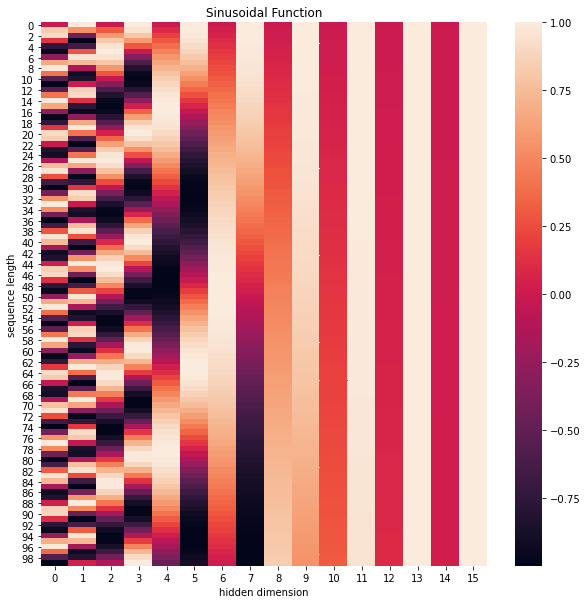

In [14]:
pe = PositionalEncoding(16, 0, 100)
positional_encoding = pe.forward(Variable(torch.zeros(1, 100, 16).to(DEVICE)))
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding.squeeze().cpu().numpy())
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")

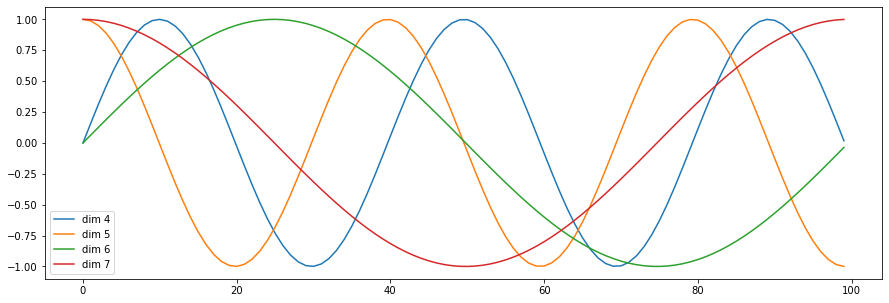

In [17]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)).to(DEVICE))
plt.plot(np.arange(100), y[0, :, 4:8].data.cpu().numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### 2. self attention（自注意力机制）

1. multi-attention的实现过程
2. 数据shape的变化
3. attention mask的实现方式


In [18]:
%%html

<img src="./imgs/attention_0.jpg", width=600>
<img src="./imgs/attention_1.jpg", width=600>

In [19]:
%%html
<img src="./imgs/multi-head.png", width=550>


**除以$\sqrt{d_k}$的解释**  
  
假设 $q$ 和 $k$ 是独立的随机变量，平均值为 0，方差 1，这样他们的**点积后**形成的注意力矩阵为 $q⋅k=\sum_{i=1}^{d_k}{q_i k_i}$，均值为 0 但**方差放大为 $d_k$** 。为了抵消这种影响，我们用$\sqrt{d_k}$来缩放点积，可以使得Softmax归一化时结果更稳定（不至于点积后得到注意力矩阵的值差别太大），以便**反向传播时获取平衡的梯度**

### 3. Attention Mask

In [20]:
%%html
<img src="./imgs/attention_mask.jpg", width=750>
<img src="./imgs/attention_mask2.jpg", width=550>

注意, 在上面$self \ attention$的计算过程中, 我们通常使用$mini \ batch$来计算, 也就是一次计算多句话, 也就是$X$的维度是$[batch \ size, \ sequence \ length]$, $sequence \ length$是句长, 而一个$mini \ batch$是由多个不等长的句子组成的, 我们就需要按照这个$mini \ batch$中最大的句长对剩余的句子进行补齐长度, **我们一般用$0$来进行填充, 这个过程叫做$padding$**.   
  
但这时在进行$softmax$的时候就会产生问题, 回顾$softmax$函数$\sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}$, $e^0$是1, 是有值的, 这样的话$softmax$中被$padding$的部分就参与了运算, 就等于是让无效的部分参与了运算, 会产生很大隐患, 这时就需要做一个$mask$让这些无效区域不参与运算, 我们一般给无效区域**加一个很大的负数的偏置**, 也就是:  
  
$$z_{illegal} = z_{illegal} + bias_{illegal}$$
$$bias_{illegal} \to -\infty$$
$$e^{z_{illegal}} \to 0 $$  
  
经过上式的$masking$我们使无效区域经过$softmax$计算之后几乎为$0$, 这样就避免了无效区域参与计算.

在 $Transformer$ 里面，$Encoder$ 和 $Decoder $的 $Attention$ 计算都需要相应的 $Mask$ 处理，但功能却不同。  
  
在 $Encoder$ 中，就如上述介绍的，$Mask$ 就是为了让那些在一个 $batch$ 中长度较短的序列的 $padding$ 部分不参与 $Attention$ 的计算。因此我们定义一个 $Batch$ 批处理对象，它包含用于训练的 $src$（翻译前）和 $trg$（翻译后）句子，以及构造其中的 $Mask$ 掩码。  
  
**加了 $Mask$ 的 $Attention$ 原理如图（另附 $Multi\text{-}Head\ Attention$ ）：**  
> 注意：这里的 $Attention\ Mask$ 是加在 $Scale$ 和 $Softmax$ 之间  
  


In [21]:
def attention(query, key, value, mask=None, dropout=None):
    # 将query矩阵的最后一个维度值作为d_k
    d_k = query.size(-1)
    # 将key的最后两个维度互换(转置)，才能与query矩阵相乘，乘完了还要除以d_k开根号
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # 如果存在要进行mask的内容，则将那些为0的部分替换成一个很大的负数
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    # 将mask后的attention矩阵按照最后一个维度进行softmax
    p_attn = F.softmax(scores, dim=-1)
    # 如果dropout参数设置为非空，则进行dropout操作
    if dropout is not None:
        p_attn = dropout(p_attn)
    # 最后返回注意力矩阵跟value的乘积，以及注意力矩阵 ;[batch_size, h, seq_len, embedding_size//h]
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        # 保证可以整除
        assert d_model % h == 0
        # 得到一个head的attention表示维度
        self.d_k = d_model // h
        # head数量
        self.h = h
        # 定义4个全连接函数，供后续作为WQ，WK，WV矩阵和最后h个多头注意力矩阵concat之后进行变换的矩阵
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        # query的第一个维度值为batch size
        nbatches = query.size(0)
        # 将embedding层乘以WQ，WK，WV矩阵(均为全连接)
        # 并将结果拆成h块，然后将第二个和第三个维度值互换(具体过程见上述解析)
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]
        # 调用上述定义的attention函数计算得到h个注意力矩阵跟value的乘积，以 及注意力矩阵
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 将h个多头注意力矩阵concat起来（注意要先把h变回到第三维的位置）
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        # 使用self.linears中构造的最后一个全连接函数来存放变换后的矩阵进行返回
        return self.linears[-1](x)

In [22]:
### 理解mask机制，可忽略####
import torch.nn.functional as F
import numpy as np
a = torch.Tensor([1,2,3,0])
a_mask = (a != 0).unsqueeze(-2)
a = a.masked_fill(a_mask ==0, value=-np.inf)

print(a_mask)
print(a)
b = F.softmax(a)
print(b)

tensor([[ True,  True,  True, False]])
tensor([[1., 2., 3., -inf]])
tensor([[0.0900, 0.2447, 0.6652, 0.0000]])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


参数里面的 $h$ 和 $d_{model}$ 分别表示注意力头的个数，以及模型的隐层单元数。  
  
另外在 $\_\_init\_\_$ 函数中，我们定义了 $self.linears = clones(nn.Linear(d_{model},\; d_{model}),\; 4),\; clone(x,\; N)$ 即为深拷贝N份，这里定义了4个全连接函数，实际上是3+1，其中的3个分别是Q、K和V的变换矩阵，最后一个是用于最后将 $h$ 个多头注意力矩阵concat之后进行变换的矩阵。  
  
在 $forward$ 函数中，是首先将 $query$、$key$ 和 $value$ 进行相应的变换，然后需要经过 $attention$ 这个函数的计算，这个函数实际上就是论文中“Scaled Dot-Product Attention”这个模块的计算

In [23]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # 将输入与输出的单词id表示的数据规范成整数类型
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # 对于当前输入的句子非空部分进行判断成bool序列
        # 并在seq length前面增加一维，形成维度为 1×seq length 的矩阵
        self.src_mask = (src != pad).unsqueeze(-2)
        # 如果输出目标不为空，则需要对decoder要使用到的target句子进行mask
        if trg is not None:
            # decoder要用到的target输入部分
            self.trg = trg[:, :-1]
            # decoder训练时应预测输出的target结果
            self.trg_y = trg[:, 1:]
            # 将target输入部分进行attention mask
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # 将应输出的target结果中实际的词数进行统计
            self.ntokens = (self.trg_y != pad).data.sum()
    
    # Mask掩码操作
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### 4. Layer Normalization 和残差连接

1). **LayerNorm**:   
  
$Layer Normalization$的作用是把神经网络中隐藏层归一为标准正态分布, 也就是 $i.i.d$（独立同分布）, 以起到加快训练速度, 加速收敛的作用:
$$\mu_{i}=\frac{1}{m} \sum^{m}_{i=1}x_{ij}$$  
  
上式中以矩阵的行$(row)$为单位求均值;  
  
$$\sigma^{2}_{j}=\frac{1}{m} \sum^{m}_{i=1}
(x_{ij}-\mu_{j})^{2}$$  
  
上式中以矩阵的行$(row)$为单位求方差;  
  
$$LayerNorm(x)=\alpha \odot \frac{x_{ij}-\mu_{i}}
{\sqrt{\sigma^{2}_{i}+\epsilon}} + \beta \tag{eq.5}$$  
  
然后用**每一行**的**每一个元素**减去**这行的均值**, 再除以**这行的标准差**, 从而得到归一化后的数值, $\epsilon$是为了防止除$0$;   
之后引入两个**可训练参数**$\alpha, \ \beta$来弥补归一化的过程中损失掉的信息, 注意$\odot$表示元素相乘而不是点积, 我们一般初始化$\alpha$为全$1$, 而$\beta$为全$0$.  



> 注：有关Batch Normalization和Layer Normalization的区别可参考如下文章——https://zhuanlan.zhihu.com/p/33173246
- 各种归一化： https://www.jianshu.com/p/05de1f989790  或者
https://mlexplained.com/2018/11/30/an-overview-of-normalization-methods-in-deep-learning/

- 可以增加训练速度，防止过拟合：如果没有归一化，数据分布都不同，网络需要更大的开销去学习新的分布，造成网络模型更加复杂，因此容易发生过拟合，网络收敛也比较慢。
- 可以避免激活函数进入非线性饱和区，从而造成梯度弥散问题

2). **残差连接**:   
  
我们在上一步得到了经过注意力矩阵加权之后的$V$, 也就是$Attention(Q, \ K, \ V)$, 我们对它进行一下转置, 使其和$X_{embedding}$的维度一致, 也就是$[batch \ size, \ sequence \ length, \ embedding \ dimension]$, 然后把他们加起来做残差连接, 直接进行元素相加, 因为他们的维度一致:   
  
$$X_{embedding} + Attention(Q, \ K, \ V)$$  
  
在之后的运算里, 每经过一个模块的运算, 都要把运算之前的值和运算之后的值相加, 从而得到残差连接, 训练的时候可以使梯度直接走捷径反传到最初始层:  
  
$$X + SubLayer(X) \tag{eq. 6}$$  
  
> **注意：这里我们对$SubLayer(X)$一般会进行dropout后再与X连接，即　$X + Dropout(SubLayer(X))$**
> 

- 网络退化：在神经网络可以收敛的前提下，随着网络深度增加，网络的表现先是逐渐增加至饱和，然后迅速下降

Deep Residual Learning for Image Recognition http://arxiv.org/abs/1512.03385

https://zhuanlan.zhihu.com/p/80226180



In [24]:
%%html
<img src="./imgs/net.png", width=600>

In [25]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # 初始化α为全1, 而β为全0
        self.a_2 = nn.Parameter(torch.ones(features))# 可训练参数 𝛼, 𝛽 ，因此会在model.parameter中
        self.b_2 = nn.Parameter(torch.zeros(features))
        # 平滑项
        self.eps = eps

    def forward(self, x):
        # 按最后一个维度计算均值和方差
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        # 返回Layer Norm的结果
        return self.a_2 * (x - mean) / torch.sqrt(std ** 2 + self.eps) + self.b_2

以上是 $LayerNormalization$ 的实现，其实PyTorch里面已经集成好了nn.LayerNorm，这里实现出来是为了学习其中的原理。而实际中，为了代码简洁，可以直接使用PyTorch里面实现好的函数。

In [26]:
class SublayerConnection(nn.Module):
    """
    SublayerConnection的作用就是把Multi-Head Attention和Feed Forward层连在一起
    只不过每一层输出之后都要先做Layer Norm再残差连接
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # 返回Layer Norm和残差连接后结果
        return x + self.dropout(sublayer(self.norm(x)))

### 5. Transformer Encoder 整体结构

经过上面4个步骤, 我们已经基本了解到来$transformer$编码器的主要构成部分, 我们下面用公式把一个$transformer \ block$的计算过程整理一下:    
  
1). **字向量与位置编码:**   
$$X = EmbeddingLookup(X) + PositionalEncoding \tag{eq.2}$$
$$X \in \mathbb{R}^{batch \ size  \ * \  seq. \ len. \  * \  embed. \ dim.} $$  
  
2). **自注意力机制:**   
$$Q = Linear(X) = XW_{Q}$$ 
$$K = Linear(X) = XW_{K} \tag{eq.3}$$
$$V = Linear(X) = XW_{V}$$
$$X_{attention} = SelfAttention(Q, \ K, \ V) \tag{eq.4}$$  
  
3). **残差连接与$Layer \ Normalization$**
$$X_{attention} = LayerNorm(X_{attention}) \tag{eq. 5}$$
$$X_{attention} = X + X_{attention} \tag{eq. 6}$$  
  
4). **$FeedForward$，其实就是两层线性映射并用激活函数（比如说$ReLU$）激活：**   
$$X_{hidden} = Linear(Activate(Linear(X_{attention}))) \tag{eq. 7}$$  
  
5). **重复3).:**
$$X_{hidden} = LayerNorm(X_{hidden})$$
$$X_{hidden} = X_{attention} + X_{hidden}$$
$$X_{hidden} \in \mathbb{R}^{batch \ size  \ * \  seq. \ len. \  * \  embed. \ dim.} $$

In [27]:
%%html
<img src="./imgs/encoder2.png", width=750>

In [28]:
def clones(module, N):
    """
    克隆模型块，克隆的模型块参数不共享
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

$Feed Forward$（前馈网络）层其实就是两层线性映射并用激活函数激活

In [29]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

$Encoder$ 由 $N=6$ 个相同的层组成。

In [30]:
class Encoder(nn.Module):
    # layer = EncoderLayer
    # N = 6
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # 复制N个encoder layer
        self.layers = clones(layer, N)
        # Layer Norm
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        使用循环连续eecode N次(这里为6次)
        这里的Eecoderlayer会接收一个对于输入的attention mask处理
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

每层 $Encoder\ Block$ 都有两个子层组成。第一个子层实现了“多头”的 $Self\text{-}attention$，第二个子层则是一个简单的 $Position\text{-}wise$ 的全连接前馈网络。

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # SublayerConnection的作用就是把multi和ffn连在一起
        # 只不过每一层输出之后都要先做Layer Norm再残差连接
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # d_model
        self.size = size

    def forward(self, x, mask):
        # 将embedding层进行Multi head Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 注意到attn得到的结果x直接作为了下一层的输入
        return self.sublayer[1](x, self.feed_forward)

## 三. 解码器部分（Decoder）

In [32]:
%%html

<img src="./imgs/decoder.jpg", width=800>

接着来看 $Decoder$ 部分（右半部分），它同样也是由 $N$ 层（在论文中，仍取 $N=6$ ）堆叠起来。  
> 对于其中的每一层，除了与 $Encoder$ 中相同的 $self\text{-}attention$ 及 $Feed Forward$ 两层之外，还在中间插入了一个传统的 $Encoder\text{-}Decoder$ 框架中的 $context\text{-}attention$ 层（上图中的$sub\text{-}layer\ 2$），即将 $Decoder$ 的输出作为 $query$ 去查询 $Encoder$ 的输出，同样用的是 $Multi\text{-}Head\ Attention$ ，使得在 $Decode$ 的时候能看到 $Encoder$ 的所有输出。  
  
这里明确一下 **$Decoder$ 的输入输出和解码过程：**

- 输入：$Encoder$ 的输出 & 对应 $i-1$ 位置 $Decoder$ 的输出。所以中间的 $Attention$ 不是 $Self\text{-}Attention$ ，它的 $K$，$V$ 来自 $Encoder$ ，Q来自上一位置 $Decoder$ 的输出
- 输出：对应 $i$ 位置的输出词的概率分布
- 解码：这里要特别注意一下，编码可以并行计算，一次性全部encoding出来，但解码不是一次把所有序列解出来的，而是像rnn一样一个一个解出来的，因为要用上一个位置的输入当作 $Attention$ 的 $query$

这里 ** $Encoder$ 和 $Decoder$ 的 $Attention$ 的区别如下图所示**  


In [33]:
%%html
<img src="./imgs/attention.png", width=800>

In [34]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        # 复制N个decoder layer
        self.layers = clones(layer, N)
        # Layer Norm
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        使用循环连续decode N次(这里为6次)
        这里的Decoderlayer会接收一个对于输入的attention mask处理
        和一个对输出的attention mask + subsequent mask处理
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        # Self-Attention
        self.self_attn = self_attn
        # 与Encoder传入的Context进行Attention
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # 用m来存放encoder的最终hidden表示结果
        m = memory
        # self-attention的q，k和v均为decoder hidden
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # context-attention的q为decoder hidden，而k和v为encoder hidden
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

明确了解码过程之后最上面的图就很好懂了，这里主要的不同就是新加的另外要说一下新加的attention多加了一个 $subsequent\_mask$ ，因为训练时的output都是ground truth，这样可以确保预测第 $i$ 个位置时不会接触到未来的信息，具体解释如下。

对于 $Encoder$ 中 $src$ 的 $mask$ 方式就比较简单，直接把 $pad$ 部分给 $mask$ 掉即可。  
但对于 $Decoder$ 中 $trg$ 的 $mask$ 计算略微复杂一些，不仅需要把 $pad$ 部分 $mask$ 掉，还需要进行一个 $subsequent\_mask$ 的操作。  
即作为 $decoder$，在预测当前步的时候，是不能知道后面的内容的，即 $attention$ 需要加上 $mask$，将当前步之后的分数全部置为$-\infty$，然后再计算 $softmax$，以防止发生数据泄露。这种 $Masked$ 的 $Attention$ 是考虑到输出 $Embedding$ 会偏移一个位置，确保了生成位置 $i$ 的预测时，仅依赖小于 $i$ 的位置处的已知输出，相当于把后面不该看到的信息屏蔽掉。  

In [35]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # 设定subsequent_mask矩阵的shape
    attn_shape = (1, size, size)
    # 生成一个右上角(不含主对角线)为全1，左下角(含主对角线)为全0的subsequent_mask矩阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # 返回一个右上角(不含主对角线)为全False，左下角(含主对角线)为全True的subsequent_mask矩阵
    return torch.from_numpy(subsequent_mask) == 0

我们可视化一下 $subsequent\_mask$ 矩阵的形式，直观进行理解。  
这里的 $Attention mask$ 图显示了允许每个目标词（行）查看的位置（列）。在训练期间，当前解码位置的词不能 $Attend$ 到后续位置的词。  
  
> 这里是给定一个序列长度size，生成一个下三角矩阵，在主对角线右上的都是 False，其示意图如下：  



In [36]:
%%html
<img src="./imgs/subsequent_mask.png", width=450>  

就是在decoder层的self-Attention中，由于生成 $s_i$ 时， $s_{i+1}$ 并没有产生，所以不能有 $s_i$ 和 $s_{i+1}$ 的关联系数，即只有下三角矩阵有系数，即下图中**`黄色部分`**。

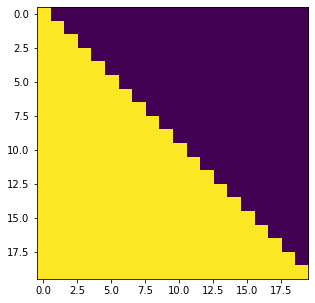

In [37]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## 四. Transformer模型
  
最后，我们把 $Encoder$ 和 $Decoder$ 组成 $Transformer$ 模型

In [38]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator 

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # encoder的结果作为decoder的memory参数传入，进行decode
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

In [39]:
class Generator(nn.Module):
    # vocab: tgt_vocab
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode后的结果，先进入一个全连接层变为词典大小的向量
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 然后再进行log_softmax操作(在softmax结果上再做多一次log运算)
        return F.log_softmax(self.proj(x), dim=-1)

**定义设置超参并连接完整模型的函数**

In [40]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy
    # 实例化Attention对象
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    # 实例化FeedForward对象
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    # 实例化PositionalEncoding对象
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    # 实例化Transformer模型对象
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # 这里初始化采用的是nn.init.xavier_uniform
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

## 五. 模型训练

**标签平滑**

在训练期间，我们采用了值$\epsilon_{ls}=0.1$的标签平滑（参见： https://arxiv.org/pdf/1512.00567.pdf ），其实还是从$Computer\; Vision$上搬过来的，具体操作可以看下面的代码实现，**在这里不作为重点**。  
  
这种做法提高了困惑度，因为模型变得更加不确定，但提高了准确性和BLEU分数。  
>我们使用 $KL\; div\; loss$（KL散度损失）实现标签平滑。  
对于输出的分布，从原始的 $one\text{-}hot$ 分布转为在groundtruth上使用一个confidence值，而后其他的所有非groudtruth标签上采用 $\frac{1 - confidence}{odim - 1}$ 作为概率值进行平滑。

In [41]:
class LabelSmoothing(nn.Module):
    """标签平滑处理
    其实就是用以下公式对真实标签概率分布q_i进行改造，以克服one-hot的缺点：
    qi=1-smoothing ，   (if i=y)
    qi=smoothing / (self.size - 1) ，otherwise
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        """
        获取标签平滑分布后的true_dist
   
        x: predict出的N个样本，M个标签的概率，shape(N，M) 
        target: 表示true label index
        """
        assert x.size(1) == self.size
        true_dist = x.data.clone() 
        true_dist.fill_(self.smoothing / (self.size - 2)) # 默认填充 smoothing / (self.size - 1) 可以在例子中打印出来理解
        #print(true_dist)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)# 在target位置，将self.confidence填充
        #print(true_dist)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

这里的size是输出词表的大小，smoothing是用于分摊在非groundtruth上面的概率值。

在这里，我们可以看到标签平滑的示例。

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)


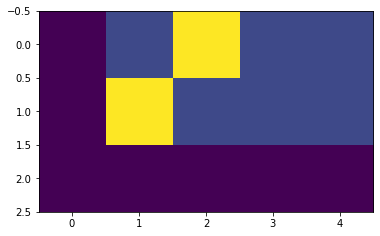

In [42]:
# Label smoothing的例子
crit = LabelSmoothing(5, 0, 0.4)  # 设定一个ϵ=0.4

predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))# 第二个target参数，设定正确标签的位置


# Show the target distributions expected by the system.
print(crit.true_dist)
plt.imshow(crit.true_dist)

如果对给定的选择非常有信心，标签平滑实际上会开始惩罚模型。

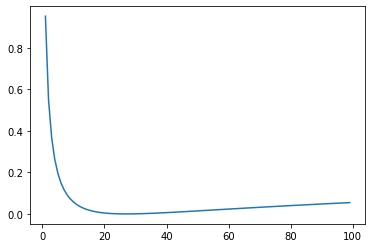

In [43]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    #print(predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

**计算损失**

In [44]:
class SimpleLossCompute:
    """
    简单的计算损失和进行参数反向传播更新训练的函数
    """
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

**optimizer优化器**

论文里面提到了他们用的优化器，是以$\beta_1=0.9、\beta_2=0.98$ 和 $\epsilon = 10^{−9}$ 的 $Adam$ 为基础，而后使用一种warmup的学习率调整方式来进行调节。  
具体公式如下：  
  
$$ lrate = d^{−0.5}_{model}⋅min(step\_num^{−0.5},\; step\_num⋅warmup\_steps^{−1.5})$$  

基本上就是用一个固定的 $warmup\_steps$ **先进行学习率的线性增长（热身）**，而后到达 $warmup\_steps$ 之后会随着 $step\_num$ 的增长，以 $step\_num$（步数）的反平方根成比例地**逐渐减小它**，他们用的 $warmup\_steps = 4000$ ，这个可以针对不同的问题自己尝试。

In [45]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

主要调节是在 $rate$ 这个函数中，其中
- $model\_size$ 即为 $d_{model}$
- $warmup$ 即为 $warmup\_steps$
- $factor$ 可以理解为初始的学习率

以下对该优化器在**不同模型大小（$model\_size$）**和**不同超参数（$marmup$）值**的情况下的学习率（$lrate$）曲线进行示例。 

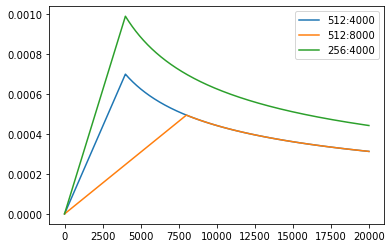

In [46]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

**训练迭代**

接下来，我们创建一个通用的训练和评分功能来跟踪损失。 我们传入一个上面定义的损失计算函数，它也处理参数更新。

In [47]:
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.

    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)# 调用SimpleLossCompute

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens


def train(data, model, criterion, optimizer):
    """
    训练并保存模型
    """
    # 初始化模型在dev集上的最优Loss为一个较大值
    best_dev_loss = 1e5
    
    for epoch in range(EPOCHS):
        # 模型训练
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # 在dev集上进行loss评估
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: %f' % dev_loss)
        # 如果当前epoch的模型在dev集上的loss优于之前记录的最优loss则保存当前模型，并更新最优loss值
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), SAVE_FILE)
            best_dev_loss = dev_loss
            print('****** Save model done... ******')
        print()

In [51]:
# 数据预处理
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)

# 初始化模型
model = make_model(
                    src_vocab, 
                    tgt_vocab, 
                    LAYERS, 
                    D_MODEL, 
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

# 训练
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

src_vocab 5493
tgt_vocab 3194
>>>>>>> start train
Epoch 0 Batch: 0 Loss: 8.051223 Tokens per Sec: 1.224183s
Epoch 0 Batch: 50 Loss: 7.249323 Tokens per Sec: 3.933817s
Epoch 0 Batch: 100 Loss: 6.156641 Tokens per Sec: 3.902736s
Epoch 0 Batch: 150 Loss: 5.672835 Tokens per Sec: 3.899318s
Epoch 0 Batch: 200 Loss: 5.510105 Tokens per Sec: 3.851603s
>>>>> Evaluate
Epoch 0 Batch: 0 Loss: 4.848499 Tokens per Sec: 3.726685s
<<<<< Evaluate loss: 5.109753
****** Save model done... ******

Epoch 1 Batch: 0 Loss: 5.179761 Tokens per Sec: 4.135985s
Epoch 1 Batch: 50 Loss: 4.891053 Tokens per Sec: 3.925025s
Epoch 1 Batch: 100 Loss: 4.626435 Tokens per Sec: 4.015536s
Epoch 1 Batch: 150 Loss: 4.578291 Tokens per Sec: 4.006769s
Epoch 1 Batch: 200 Loss: 4.797964 Tokens per Sec: 3.955960s
>>>>> Evaluate
Epoch 1 Batch: 0 Loss: 4.062479 Tokens per Sec: 5.400898s
<<<<< Evaluate loss: 4.344451
****** Save model done... ******

Epoch 2 Batch: 0 Loss: 4.491321 Tokens per Sec: 4.227937s
Epoch 2 Batch: 50 Loss: 

>>>>> Evaluate
Epoch 18 Batch: 0 Loss: 0.248005 Tokens per Sec: 5.108339s
<<<<< Evaluate loss: 0.371182
****** Save model done... ******

Epoch 19 Batch: 0 Loss: 0.413096 Tokens per Sec: 4.314566s
Epoch 19 Batch: 50 Loss: 0.486466 Tokens per Sec: 4.108336s
Epoch 19 Batch: 100 Loss: 0.275728 Tokens per Sec: 4.104908s
Epoch 19 Batch: 150 Loss: 0.421464 Tokens per Sec: 3.946922s
Epoch 19 Batch: 200 Loss: 0.536440 Tokens per Sec: 4.004384s
>>>>> Evaluate
Epoch 19 Batch: 0 Loss: 0.226814 Tokens per Sec: 5.424840s
<<<<< Evaluate loss: 0.314994
****** Save model done... ******

<<<<<<< finished train, cost 864.0002 seconds


## 六. 模型预测

In [52]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    传入一个训练好的模型，对指定数据进行预测
    """
    # 先用encoder进行encode
    memory = model.encode(src, src_mask)
    # 初始化预测内容为1×1的tensor，填入开始符('BOS')的id，并将type设置为输入数据类型(LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 遍历输出的长度下标
    for i in range(max_len-1):
        # decode得到隐层表示
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 将隐藏表示转为对词典各词的log_softmax概率分布表示
        prob = model.generator(out[:, -1])
        # 获取当前位置最大概率的预测词id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # 将当前位置预测的字符id与之前的预测内容拼接起来
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


def evaluate(data, model):
    """
    在data上用训练好的模型进行预测，打印模型翻译结果
    """
    # 梯度清零
    with torch.no_grad():
        # 在data的英文数据长度上遍历下标
        for i in range(len(data.dev_en)):
            # 打印待翻译的英文句子
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]])
            print("\n" + en_sent)
            # 打印对应的中文句子答案
            cn_sent = " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]])
            print("".join(cn_sent))
            
            # 将当前以单词id表示的英文句子数据转为tensor，并放如DEVICE中
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            # 增加一维
            src = src.unsqueeze(0)
            # 设置attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # 用训练好的模型进行decode预测
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # 初始化一个用于存放模型翻译结果句子单词的列表
            translation = []
            # 遍历翻译输出字符的下标（注意：开始符"BOS"的索引0不遍历）
            for j in range(1, out.size(1)):
                # 获取当前下标的输出字符
                sym = data.cn_index_dict[out[0, j].item()]
                # 如果输出字符不为'EOS'终止符，则添加到当前句子的翻译结果列表
                if sym != 'EOS':
                    translation.append(sym)
                # 否则终止遍历
                else:
                    break
            # 打印模型翻译输出的中文句子结果
            print("translation: %s" % " ".join(translation))


In [53]:
# 预测
# 加载模型
model.load_state_dict(torch.load(SAVE_FILE))
# 开始预测
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)         
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS look around . EOS
BOS 四 处 看 看 。 EOS
translation: 看 。

BOS hurry up . EOS
BOS 趕 快 ! EOS
translation: 快 点 ！

BOS keep trying . EOS
BOS 继 续 努 力 。 EOS
translation: 继 续 努 力 。

BOS take it . EOS
BOS 拿 走 吧 。 EOS
translation: 拿 走 吧 。

BOS birds fly . EOS
BOS 鳥 類 飛 行 。 EOS
translation: 鳥 類 飛 行 。

BOS hurry up . EOS
BOS 快 点 ！ EOS
translation: 快 点 ！

BOS look there . EOS
BOS 看 那 里 。 EOS
translation: 看 那 里 。

BOS how annoying ! EOS
BOS 真 烦 人 。 EOS
translation: 真 烦 人 。

BOS get serious . EOS
BOS 认 真 点 。 EOS
translation: 认 真 是 认 真 的 。

BOS once again . EOS
BOS 再 一 次 。 EOS
translation: 再 一 次 。

BOS stay sharp . EOS
BOS 保 持 警 惕 。 EOS
translation: 保 持 警 惕 。

BOS i won ! EOS
BOS 我 赢 了 。 EOS
translation: 我 赢 了 。

BOS get away ! EOS
BOS 滾 ！ EOS
translation: 走 開 ！

BOS i resign . EOS
BOS 我 放 弃 。 EOS
translation: 我 放 弃 。

BOS how strange ! EOS
BOS 真 奇 怪 。 EOS
translation: 真 奇 怪 。

BOS tom UNK . EOS
BOS 汤 姆 脸 红 了 。 EOS
translation: 汤 姆 脸 红 了 。

BOS who cares ? EOS
BOS 爱 谁 谁 。 EOS


translation: 汤 姆 冷 静 下 来 了 。

BOS please speak more loudly . EOS
BOS 請 說 大 聲 一 點 兒 。 EOS
translation: 請 說 更 大 聲 一 點 。

BOS keep next sunday free . EOS
BOS 把 下 周 日 空 出 来 。 EOS
translation: 下 周 日 空 。

BOS i made a mistake . EOS
BOS 我 犯 了 一 個 錯 。 EOS
translation: 我 犯 了 个 错 误 。

BOS i like your room . EOS
BOS 我 喜 欢 你 的 房 间 。 EOS
translation: 我 喜 欢 你 的 房 间 。

BOS he admitted his guilt . EOS
BOS 他 承 認 他 有 罪 。 EOS
translation: 他 承 認 他 有 罪 。

BOS prices have dropped recently . EOS
BOS 最 近 物 價 已 經 下 降 。 EOS
translation: 最 近 物 價 已 經 到 了 。

BOS i want a dog . EOS
BOS 我 想 要 一 隻 狗 。 EOS
translation: 我 想 要 一 隻 狗 。

BOS i 'll do it . EOS
BOS 我 會 做 的 。 EOS
translation: 我 會 做 的 。

BOS have a good christmas . EOS
BOS 祝 您 有 一 個 愉 快 的 聖 誕 節 。 EOS
translation: 祝 你 好 梦 。

BOS he speaks too fast . EOS
BOS 他 说 话 太 快 了 。 EOS
translation: 他 能 讲 得 快 点 。

BOS i was so homesick . EOS
BOS 我 很 想 家 。 EOS
translation: 我 很 想 家 。

BOS i have many UNK . EOS
BOS 我 有 许 多 唱 片 。 EOS
translation: 我 玩 得 很 多 。

BOS you 're stil

translation: 我 喉 嚨 裡 喝 一 下 。

BOS i agree with him . EOS
BOS 我 同 意 他 。 EOS
translation: 我 同 意 他 。

BOS this shirt needs UNK . EOS
BOS 这 衬 衫 需 要 熨 。 EOS
translation: 这 衬 衫 需 要 熨 。

BOS i 've got time . EOS
BOS 我 有 时 间 。 EOS
translation: 我 有 时 间 。

BOS could you sign here ? EOS
BOS 你 能 在 这 里 签 名 吗 ? EOS
translation: 你 能 在 这 里 签 名 吗 ？

BOS i 'm so fat . EOS
BOS 我 好 胖 哦 。 EOS
translation: 我 好 胖 哦 。

BOS tom is very talented . EOS
BOS 汤 姆 多 才 多 艺 。 EOS
translation: 汤 姆 是 很 有 才 华 的 。

BOS i miss my children . EOS
BOS 我 想 念 我 的 孩 子 。 EOS
translation: 我 想 念 我 的 孩 子 。

BOS do you know me ? EOS
BOS 你 认 识 我 吗 ？ EOS
translation: 你 认 识 我 吗 ？

BOS it is too late . EOS
BOS 太 晚 了 。 EOS
translation: 太 晚 了 。

BOS do you study english ? EOS
BOS 你 学 英 语 吗 ？ EOS
translation: 你 学 英 语 吗 ？

BOS he comes from england . EOS
BOS 他 来 自 英 格 兰 。 EOS
translation: 他 来 自 英 格 兰 。

BOS he studied very hard . EOS
BOS 他 学 习 非 常 努 力 。 EOS
translation: 他 学 习 非 常 努 力 。

BOS it 's very UNK . EOS
BOS 它 真 是 不 舒 服 。 EOS
translat

translation: 泪 水 沿 着 我 的 面 。

BOS he suddenly became very happy . EOS
BOS 他 突 然 變 得 非 常 開 心 。 EOS
translation: 他 突 然 變 得 很 開 心 。

BOS i am sixteen years old . EOS
BOS 我 1 6 岁 了 。 EOS
translation: 我 十 年 1 0 岁 了 。

BOS spring is my favorite season . EOS
BOS 春 天 是 我 最 喜 爱 的 季 节 。 EOS
translation: 春 天 是 我 最 喜 欢 的 季 节 。

BOS i 'm looking for you . EOS
BOS 我 在 找 你 。 EOS
translation: 我 正 在 找 你 。

BOS can i rest a bit ? EOS
BOS 我 能 休 息 一 会 儿 吗 ？ EOS
translation: 我 能 休 息 一 会 儿 吗 ？

BOS may i eat this orange ? EOS
BOS 我 可 以 吃 這 個 柳 橙 嗎 ？ EOS
translation: 我 能 吃 这 只 橙 子 吗 ？

BOS i 'm able to speak . EOS
BOS 我 能 说 。 EOS
translation: 我 能 说 话 。

BOS our school begins at eight-thirty . EOS
BOS 我 們 學 校 在 八 點 半 開 始 上 課 。 EOS
translation: 我 們 學 校 在 八 點 半 開 始 上 課 。

BOS there 's nothing to forgive . EOS
BOS 没 什 么 可 原 谅 的 。 EOS
translation: 没 什 么 可 原 谅 的 。

BOS he saw her and UNK . EOS
BOS 他 看 到 她 就 臉 紅 了 。 EOS
translation: 他 看 到 她 和 她 一 起 来 。

BOS tom came home early yesterday . EOS
BOS 湯 姆 昨 天 提 早 回 來 了 

translation: 洗 手 里 洗 手 。

BOS we 'll always be friends . EOS
BOS 我 们 永 远 都 会 是 朋 友 。 EOS
translation: 我 们 永 远 都 会 是 朋 友 。

BOS speaking in english is fun . EOS
BOS 說 英 語 很 有 趣 。 EOS
translation: 說 英 語 很 有 趣 。

BOS i can see the light . EOS
BOS 我 能 看 到 光 線 。 EOS
translation: 我 能 看 到 光 線 。

BOS he often eats breakfast there . EOS
BOS 他 常 常 在 那 裡 吃 早 餐 。 EOS
translation: 他 常 在 那 裡 吃 早 餐 。

BOS they did n't like you . EOS
BOS 他 们 不 喜 欢 你 。 EOS
translation: 他 们 不 喜 欢 你 。

BOS how deep is the hole ? EOS
BOS 這 個 洞 多 深 ? EOS
translation: 這 個 洞 多 深 ?

BOS she is watering the flowers . EOS
BOS 她 正 在 澆 花 。 EOS
translation: 她 正 在 澆 花 。

BOS i 'll drive to UNK . EOS
BOS 我 會 開 車 到 底 特 律 。 EOS
translation: 我 會 開 車 。

BOS guess what he told me . EOS
BOS 猜 猜 看 他 告 訴 了 我 什 麼 。 EOS
translation: 猜 看 他 告 訴 了 我 什 麼 。

BOS he 'll wait for you . EOS
BOS 他 會 等 你 。 EOS
translation: 他 會 等 你 。

BOS my UNK is very UNK . EOS
BOS 我 的 頭 皮 非 常 UNK 。 EOS
translation: 我 的 頭 皮 非 常 。

BOS she spoke through an interpreter 

translation: 我 已 經 喝 啤 酒 了 。

BOS my mother boiled ten eggs . EOS
BOS 妈 妈 煮 了 十 只 蛋 。 EOS
translation: 妈 妈 煮 了 十 只 蛋 。

BOS do you know this song ? EOS
BOS 你 知 道 這 首 歌 嗎 ？ EOS
translation: 你 知 道 這 首 歌 嗎 ？

BOS being rich is n't enough . EOS
BOS 有 钱 还 不 够 。 EOS
translation: 這 對 不 夠 夠 夠 夠 夠 的 原 因 。

BOS please tell me about it . EOS
BOS 请 告 诉 我 它 的 事 情 。 EOS
translation: 請 告 訴 我 。

BOS he is fluent in french . EOS
BOS 他 说 法 语 说 得 很 流 利 。 EOS
translation: 他 说 法 语 说 得 流 利 。

BOS that 's what i like . EOS
BOS 我 就 喜 欢 它 。 EOS
translation: 那 就 是 我 喜 欢 的 。

BOS he is an UNK person . EOS
BOS 他 是 个 UNK UNK 逼 人 的 的 人 。 EOS
translation: 他 是 个 有 人 。

BOS my attitude towards him changed . EOS
BOS 我 对 他 的 态 度 变 了 。 EOS
translation: 我 对 他 的 态 度 变 了 。

BOS she 's not a child . EOS
BOS 她 不 是 小 孩 。 EOS
translation: 她 不 是 小 孩 。

BOS she is everything to him . EOS
BOS 她 是 他 的 一 切 。 EOS
translation: 她 是 他 的 一 切 。

BOS i heard the door close . EOS
BOS 我 听 到 门 关 了 。 EOS
translation: 我 聽 到 了 門 。

BOS the topic

translation: 我 们 收 到 了 很 多 他 。

BOS she greeted me with a smile . EOS
BOS 她 用 一 个 微 笑 迎 接 了 我 。 EOS
translation: 她 用 一 個 微 笑 迎 接 我 。

BOS do n't make fun of people . EOS
BOS 不 要 取 笑 人 。 EOS
translation: 别 取 笑 人 。

BOS what 's your favorite UNK food ? EOS
BOS 你 最 喜 歡 的 家 常 菜 是 什 麼 ？ EOS
translation: 你 最 喜 欢 的 食 物 怎 么 样 ？

BOS his life after UNK was unhappy . EOS
BOS 他 退 休 後 的 生 活 不 快 樂 。 EOS
translation: 他 的 生 活 過 於 不 快 樂 。

BOS the plane made a perfect landing . EOS
BOS 這 架 飛 機 完 美 的 著 陸 了 。 EOS
translation: 完 美 的 收 集 使 用 完 美 的 收 。

BOS it all depends on the weather . EOS
BOS 一 切 都 取 決 於 天 氣 。 EOS
translation: 这 都 取 決 於 天 氣 。

BOS my heart was filled with happiness . EOS
BOS 我 心 里 充 满 着 快 乐 。 EOS
translation: 我 心 里 充 满 着 快 乐 。

BOS she laid the work on him . EOS
BOS 她 派 他 去 工 作 了 。 EOS
translation: 她 派 他 去 工 作 了 。

BOS they were listening to the radio . EOS
BOS 他 們 在 聽 收 音 機 。 EOS
translation: 他 們 正 在 聽 收 音 機 。

BOS six divided by two is three . EOS
BOS 六 除 以 二 得 三 。 EOS
translation: 六

translation: 他 在 他 的 房 間 裡 玩 。

BOS he is often absent from school . EOS
BOS 他 经 常 UNK 课 。 EOS
translation: 他 经 常 去 学 校 。

BOS i 'll attend the next meeting . EOS
BOS 我 会 参 加 下 次 的 会 议 。 EOS
translation: 我 會 參 加 這 個 會 議 。

BOS visitors to switzerland admire the UNK . EOS
BOS 遊 客 到 瑞 士 欣 賞 阿 爾 UNK 斯 山 。 EOS
translation: 遊 客 到 瑞 士 欣 賞 阿 爾 斯 山 。

BOS what do you want for breakfast ? EOS
BOS 你 早 餐 想 要 吃 什 麼 ？ EOS
translation: 你 早 餐 想 要 什 么 ？

BOS you might have heard of it . EOS
BOS 你 可 能 听 说 过 。 EOS
translation: 你 可 能 听 说 得 好 了 。

BOS it UNK with a loud noise . EOS
BOS 它 發 出 巨 響 爆 炸 了 。 EOS
translation: 它 花 了 一 間 聲 音 關 聲 。

BOS i was a little bit nervous . EOS
BOS 我 有 点 紧 张 。 EOS
translation: 我 有 点 紧 张 。

BOS please come as soon as possible . EOS
BOS 请 尽 快 过 来 。 EOS
translation: 请 尽 快 来 。

BOS mary is studying in her room . EOS
BOS 瑪 麗 在 她 的 房 間 裡 讀 書 。 EOS
translation: 瑪 麗 正 在 讀 她 的 房 間 。

BOS the tigers escaped from the zoo . EOS
BOS 老 虎 從 動 物 園 中 逃 出 來 了 。 EOS
translation: 老 虎 從 動 物 園 

translation: 她 在 一 毯 子 上 绑 到 了 一 根 據 。

BOS he was late for school yesterday . EOS
BOS 他 昨 天 上 学 迟 到 了 。 EOS
translation: 他 昨 天 上 学 迟 到 了 。

BOS sentences begin with a capital letter . EOS
BOS 句 子 以 一 個 大 寫 字 母 開 頭 。 EOS
translation: 句 子 以 一 個 大 寫 字 母 開 頭 。

BOS i visited my friend tom yesterday . EOS
BOS 我 昨 天 拜 訪 了 我 的 朋 友 湯 姆 。 EOS
translation: 我 昨 天 拜 訪 了 我 的 朋 友 。

BOS i will not attend the party . EOS
BOS 我 将 不 出 席 派 对 。 EOS
translation: 我 會 深 及 時 地 參 加 派 對 。

BOS he is better than anyone else . EOS
BOS 他 比 任 何 人 都 好 。 EOS
translation: 他 比 任 何 人 都 好 。

BOS she remained single all her life . EOS
BOS 她 终 生 未 婚 。 EOS
translation: 她 一 生 獨 身 。

BOS look it up in your dictionary . EOS
BOS 查 查 你 的 字 典 。 EOS
translation: 看 您 的 字 典 里 面 词 典 。

BOS no one ran ahead of him . EOS
BOS 没 有 人 跑 在 他 前 面 。 EOS
translation: 没 有 人 跑 在 他 前 面 。

BOS they were all UNK from shouting . EOS
BOS 他 們 全 都 叫 到 沙 UNK 了 。 EOS
translation: 他 们 全 都 叫 到 感 到 舒 服 。

BOS something 's wrong with my camera . EOS
BOS 我 

translation: 我 瘦 了 一 點 。

BOS the UNK is in the UNK . EOS
BOS 桌 布 在 櫥 櫃 裡 。 EOS
translation: 在 这 种 情 况 。

BOS they got married six months ago . EOS
BOS 他 們 六 個 月 前 結 婚 了 。 EOS
translation: 他 們 六 個 月 前 結 婚 了 。

BOS london is famous for its fog . EOS
BOS 倫 敦 以 霧 著 名 。 EOS
translation: 倫 敦 以 霧 著 名 。

BOS the lecture lasted for two hours . EOS
BOS 這 場 演 講 持 續 了 兩 個 小 時 。 EOS
translation: 這 場 演 講 持 續 了 兩 個 小 時 。

BOS look what i made for you . EOS
BOS 看 我 为 你 做 了 什 么 。 EOS
translation: 看 我 为 你 做 了 什 么 。

BOS it 's obvious that he lied . EOS
BOS 顯 然 地 他 撒 了 謊 。 EOS
translation: 他 出 版 了 ， 很 明 顯 。

BOS i was alone in the classroom . EOS
BOS 我 独 自 待 在 教 室 里 。 EOS
translation: 我 被 在 教 堂 位 。

BOS where does he want to go ? EOS
BOS 他 想 去 哪 裡 ? EOS
translation: 他 想 去 哪 裡 ?

BOS she did n't have any pencils . EOS
BOS 她 一 支 铅 笔 也 没 有 。 EOS
translation: 她 一 支 铅 笔 也 没 有 。

BOS i have been busy since yesterday . EOS
BOS 我 從 昨 天 開 始 一 直 忙 著 。 EOS
translation: 我 從 昨 天 開 始 一 直 忙 。

BOS i bought a new sewin

translation: 你 该 打 扫 你 的 房 间 。

BOS a famous architect built this house . EOS
BOS 一 个 有 名 的 建 筑 师 造 了 这 栋 房 子 。 EOS
translation: 一 个 有 名 的 名 古 建 筑 师 造 了 这 个 房 子 。

BOS i ’ UNK started learning esperanto . EOS
BOS 我 開 始 學 習 世 界 語 了 。 EOS
translation: 我 開 始 學 習 世 界 語 。

BOS she felt UNK about her future . EOS
BOS 她 對 她 的 未 來 感 到 沒 有 安 全 感 。 EOS
translation: 她 感 到 那 么 可 能 的 。

BOS he wants to go to america . EOS
BOS 他 想 去 美 國 。 EOS
translation: 他 想 去 美 國 。

BOS are you sure of your facts ? EOS
BOS 你 確 定 你 的 資 料 屬 實 嗎 ？ EOS
translation: 你 確 定 你 的 資 料 屬 實 嗎 ？

BOS UNK ideas into practice is difficult . EOS
BOS 把 想 法 付 UNK 實 UNK 是 困 難 的 。 EOS
translation: 把 想 法 付 得 很 難 。

BOS what is the population of japan ? EOS
BOS 日 本 的 人 口 是 多 少 ？ EOS
translation: 日 本 的 人 口 是 多 少 ？

BOS tom got angry at the children . EOS
BOS 湯 姆 對 孩 子 們 生 氣 。 EOS
translation: 湯 姆 對 孩 子 們 生 氣 。

BOS do n't throw away this magazine . EOS
BOS 不 要 丟 掉 這 本 雜 誌 。 EOS
translation: 不 要 丟 掉 這 本 雜 誌 。

BOS it is likely to rain to

translation: 我 试 着 考 虑 。

BOS i do n't worry about the risk . EOS
BOS 我 不 担 心 风 险 。 EOS
translation: 我 不 擔 心 风 险 。

BOS i 'm as hungry as a horse . EOS
BOS 我 餓 得 像 匹 馬 。 EOS
translation: 我 真 是 （ 一 個 匹 馬 。

BOS we 'll save a seat for you . EOS
BOS 我 们 会 给 你 留 个 位 置 。 EOS
translation: 我 们 会 给 你 保 护 车 。

BOS it was been raining since early morning . EOS
BOS 從 清 晨 開 始 一 直 下 雨 。 EOS
translation: 早 上 出 发 现 了 。

BOS i had a nice chat with her . EOS
BOS 我 和 她 聊 得 很 愉 快 。 EOS
translation: 我 和 她 聊 得 很 愉 快 。

BOS i put the money into the safe . EOS
BOS 我 把 錢 放 入 保 險 櫃 裡 。 EOS
translation: 我 把 錢 放 入 保 險 櫃 裡 。

BOS have you ever climbed mt . UNK ? EOS
BOS 你 曾 爬 過 槍 岳 嗎 ? EOS
translation: 你 曾 爬 過 富 士 山 嗎 ？

BOS my mother made me take some medicine . EOS
BOS 我 媽 媽 讓 我 吃 點 藥 。 EOS
translation: 我 母 親 要 做 了 一 些 藥 給 我 。

BOS this is going to be very expensive . EOS
BOS 这 要 花 很 多 钱 。 EOS
translation: 这 是 很 多 钱 的 。

BOS let me know where you 're staying . EOS
BOS 讓 我 知 道 你 住 在 哪 裡 。 EOS
translation: 让 我 知 

translation: 我 看 見 他 游 過 了 河 。

BOS he likes watching baseball games on tv . EOS
BOS 他 喜 歡 看 電 視 上 的 棒 球 比 賽 。 EOS
translation: 他 喜 歡 看 電 視 上 的 棒 球 比 賽 。

BOS many people were killed in the war . EOS
BOS 很 多 人 在 戰 爭 中 被 殺 。 EOS
translation: 很 多 人 在 戰 爭 中 被 殺 。

BOS please add my name to the list . EOS
BOS 請 把 我 的 名 字 加 在 名 單 上 。 EOS
translation: 請 在 我 的 名 字 加 上 加 入 。

BOS they drive on the left in england . EOS
BOS 在 英 國 開 車 要 靠 左 行 駛 。 EOS
translation: 他 們 開 始 流 利 的 英 國 留 在 一 次 。

BOS this food does not agree with me . EOS
BOS 这 食 物 不 适 合 我 。 EOS
translation: 这 食 物 不 适 合 我 。

BOS his name is not on the list . EOS
BOS 他 的 名 字 不 在 名 单 里 。 EOS
translation: 他 的 名 字 不 在 名 单 外 。

BOS he gave us the signal to begin . EOS
BOS 他 給 了 我 們 信 號 讓 我 們 開 始 。 EOS
translation: 他 給 了 我 們 開 始 的 信 號 。

BOS the fire UNK the house to UNK . EOS
BOS 房 子 被 大 火 烧 成 了 灰 UNK 。 EOS
translation: 火 房 子 發 燒 了 這 棟 房 子 。

BOS there 's no one in the room . EOS
BOS 沒 有 人 在 房 間 裡 。 EOS
translation: 房 間 裡 沒 有 人 。

BOS he 

translation: 她 抱 怨 我 的 薪 水 很 低 。

BOS it is this window that he broke . EOS
BOS 他 砸 坏 的 是 这 扇 窗 。 EOS
translation: 他 砸 坏 的 是 这 扇 窗 。

BOS i found your letter in the mailbox . EOS
BOS 我 在 信 箱 中 發 現 了 你 的 信 件 。 EOS
translation: 我 在 信 箱 中 發 現 了 你 的 信 件 。

BOS they are UNK to kill the king . EOS
BOS 他 們 正 密 謀 要 殺 害 國 王 。 EOS
translation: 他 們 正 密 謀 要 殺 害 國 王 。

BOS there 's a hair in my soup . EOS
BOS 我 的 湯 裡 有 一 根 頭 髮 。 EOS
translation: 我 的 湯 裡 有 一 根 頭 髮 。

BOS she can speak english , of course . EOS
BOS 她 會 講 英 語 ， 當 然 。 EOS
translation: 她 能 说 英 语 ， 但 是 當 然 。

BOS i left my briefcase in the bus . EOS
BOS 我 把 我 的 公 事 包 留 在 公 車 上 了 。 EOS
translation: 我 把 我 的 公 事 包 留 在 了 公 車 上 。

BOS have you finished reading that book yet ? EOS
BOS 你 讀 完 那 本 書 了 嗎 ? EOS
translation: 你 讀 完 那 本 書 了 嗎 ?

BOS i 'm happy to see you here . EOS
BOS 我 很 高 興 在 這 裡 看 到 你 。 EOS
translation: 我 很 高 興 在 這 裡 看 到 你 。

BOS he took the wrong bus by mistake . EOS
BOS 他 搭 错 了 车 。 EOS
translation: 他 搭 錯 車 了 車 。

BOS the news of

translation: 紐 約 的 天 氣 怎 麼 樣 ？

BOS how long have you been in UNK ? EOS
BOS 你 在 UNK 路 多 久 了 ？ EOS
translation: 你 在 监 狱 里 多 久 了 ？

BOS what did you do with that camera ? EOS
BOS 你 用 那 台 相 機 做 了 什 麼 ？ EOS
translation: 你 用 那 台 相 機 做 了 什 麼 ?

BOS UNK UNK grew up on the UNK . EOS
BOS UNK 拉 英 UNK 爾 斯 是 在 草 原 上 長 大 的 。 EOS
translation: 天 越 長 大 。

BOS he hit his head against a rock . EOS
BOS 他 的 头 撞 倒 了 一 块 岩 石 。 EOS
translation: 他 的 头 撞 倒 了 一 块 岩 石 。

BOS i bought this book at UNK bookstore . EOS
BOS 我 在 书 商 M a r UNK z e n 那 里 买 了 这 本 书 。 EOS
translation: 我 買 了 這 本 書 店 買 了 這 本 書 。

BOS i will live in sasayama next year . EOS
BOS 我 明 年 會 住 在 筱 山 。 EOS
translation: 我 明 年 會 住 在 筱 山 。

BOS she made a mess of the work . EOS
BOS 她 工 作 做 得 亂 七 八 糟 。 EOS
translation: 她 做 了 八 點 的 工 作 。

BOS she has been dead for ten years . EOS
BOS 她 已 經 死 了 十 年 了 。 EOS
translation: 她 已 經 死 了 十 年 。

BOS i did n't believe him at first . EOS
BOS 起 初 我 不 相 信 他 。 EOS
translation: 我 簡 直 不 相 信 他 。

BOS tom is a very good t

translation: 昨 晚 不 是 很 熱 。

BOS it 's obvious that she 's sick . EOS
BOS 顯 然 地 她 生 病 了 。 EOS
translation: 顯 然 地 她 生 病 了 。

BOS i have a dog and a cat . EOS
BOS 我 有 一 隻 狗 和 一 隻 貓 。 EOS
translation: 我 有 一 只 狗 和 一 只 猫 。

BOS we elected her captain of our team . EOS
BOS 我 们 选 她 为 我 们 队 的 队 长 。 EOS
translation: 我 們 選 她 的 隊 長 。

BOS i got some sand in my eye . EOS
BOS 我 的 眼 睛 進 了 些 沙 。 EOS
translation: 我 的 眼 睛 進 了 一 些 沙 。

BOS leave me a bit of ice cream . EOS
BOS 给 我 留 点 冰 激 凌 。 EOS
translation: 给 我 留 在 冰 淇 淋 。

BOS i met him on my way home . EOS
BOS 我 在 回 家 的 路 上 遇 見 了 他 。 EOS
translation: 我 在 回 家 的 路 上 遇 見 了 他 。

BOS he is a reporter for time magazine . EOS
BOS 他 是 时 代 杂 志 的 记 者 。 EOS
translation: 他 是 时 代 杂 志 的 记 者 。

BOS i opened the box and looked inside . EOS
BOS 我 打 開 盒 子 看 看 裡 面 。 EOS
translation: 我 打 開 盒 子 看 看 看 看 看 看 看 看 電 話 。

BOS new york is on the UNK river . EOS
BOS 紐 約 位 在 哈 得 UNK 河 。 EOS
translation: 紐 約 位 在 河 裡 。

BOS long skirts are out of fashion now . EOS
BOS 現 在 長 裙 過 時 

translation: 我 們 等 了 很 準 時 。

BOS i 'm not about to ask him . EOS
BOS 我 不 想 要 問 他 。 EOS
translation: 我 不 想 要 問 他 。

BOS five years is too long to wait . EOS
BOS 五 年 太 漫 長 而 無 法 等 待 。 EOS
translation: 五 年 太 漫 長 而 無 法 等 待 。

BOS what 're your plans for the weekend ? EOS
BOS 你 週 末 有 什 麼 計 劃 ？ EOS
translation: 你 週 末 有 什 麼 計 劃 ？

BOS they gave a big party for me . EOS
BOS 他 們 為 我 辦 了 一 個 盛 大 的 派 對 。 EOS
translation: 他 們 為 了 一 個 很 大 的 派 對 給 我 。

BOS she made a new suit for him . EOS
BOS 她 做 了 一 套 新 衣 服 給 他 。 EOS
translation: 她 為 他 做 了 一 套 新 衣 服 。

BOS a fire broke out during the night . EOS
BOS 在 夜 間 發 生 了 火 災 。 EOS
translation: 在 夜 間 發 生 了 火 災 。

BOS tell me the reason why she got angry . EOS
BOS 告 诉 我 她 为 什 么 生 气 。 EOS
translation: 告 诉 我 她 为 什 么 事 。

BOS i wish to climb mt . fuji again . EOS
BOS 我 希 望 再 爬 一 次 上 富 士 山 。 EOS
translation: 我 希 望 再 爬 一 次 上 富 士 山 。

BOS he can speak french , and obviously english . EOS
BOS 他 能 说 法 语 ， 很 明 显 还 有 英 语 。 EOS
translation: 他 能 说 法 语 ， 很 明 显 还 有 英 语 。


translation: 我 下 一 站 要 下 车 。

BOS UNK UNK was blind , deaf and UNK . EOS
BOS 海 倫 凱 勒 眼 盲 ， 耳 聾 ， 又 UNK 。 EOS
translation: 海 倫 凱 勒 眼 盲 ， 耳 聾 ， 耳 聾 。

BOS the sum of 5 and 3 is 8 . EOS
BOS 五 和 三 的 總 和 是 八 。 EOS
translation: 五 和 三 的 總 和 是 八 。

BOS we 'll think about it in due time . EOS
BOS 到 时 候 我 们 再 考 虑 吧 。 EOS
translation: 我 们 偶 然 会 考 虑 到 它 。

BOS do n't let tom lie on the floor . EOS
BOS 别 让 汤 姆 躺 在 地 板 上 。 EOS
translation: 别 让 汤 姆 躺 在 地 板 上 。

BOS what is the UNK of your new book ? EOS
BOS 你 新 書 的 書 名 是 什 麼 ？ EOS
translation: 你 的 新 書 是 什 么 ？

BOS i get two hour 's exercise every day . EOS
BOS 我 每 天 做 兩 個 小 時 的 練 習 。 EOS
translation: 我 每 隔 幾 個 小 時 的 運 動 。

BOS i do n't want to fail my exams . EOS
BOS 我 不 想 不 及 格 。 EOS
translation: 我 不 想 不 到 科 学 。

BOS i was n't quite sure what to say . EOS
BOS 我 不 太 確 定 要 說 什 麼 。 EOS
translation: 我 不 太 確 定 要 說 什 麼 。

BOS tom wo n't let you in his house . EOS
BOS 汤 姆 不 会 让 你 进 他 的 屋 子 。 EOS
translation: 汤 姆 不 会 让 你 进 他 的 屋 子 。

BOS the school is five 

translation: 我 老 板 把 艰 巨 的 任 务 指 派 对 。

BOS do n't forget to put out the fire . EOS
BOS 不 要 忘 了 熄 火 。 EOS
translation: 别 忘 了 把 火 熄 火 。

BOS i do n't want him to touch me . EOS
BOS 我 不 想 被 他 感 动 。 EOS
translation: 我 不 想 让 他 感 到 应 该 联 络 。

BOS he helped me to get over the difficulties . EOS
BOS 他 帮 助 我 克 服 了 困 难 。 EOS
translation: 他 幫 助 我 困 難 。

BOS i never thought it would come to this . EOS
BOS 我 从 没 想 过 它 会 变 成 这 样 。 EOS
translation: 我 从 来 不 会 来 这 样 的 。

BOS i 'm planning to stay at the hotel . EOS
BOS 我 打 算 待 在 旅 館 裡 。 EOS
translation: 我 打 算 在 旅 馆 待 饭 。

BOS UNK , it 's going to rain tomorrow . EOS
BOS 明 天 肯 定 会 下 雨 。 EOS
translation: 明 天 要 下 雨 了 ， 天 就 要 雨 。

BOS in esperanto there are only UNK grammar rules . EOS
BOS 世 界 語 只 有 1 6 個 語 法 規 則 。 EOS
translation: 日 本 人 口 語 是 世 界 語 言 表 合 語 言 。

BOS it turned out that the rumor was false . EOS
BOS 谣 言 [ 最 后 ] 证 明 是 假 的 。 EOS
translation: 谣 言 [ 最 后 ] 证 明 是 假 的 。

BOS i guess i have n't made myself clear . EOS
BOS 我 想 我 沒 有 把 話 說 清 楚 。 EOS


translation: 今 天 不 比 昨 天 氣 。

BOS he will not be able to do the work . EOS
BOS 他 没 能 力 做 这 个 工 作 。 EOS
translation: 他 不 會 做 這 個 工 作 。

BOS i 'm glad we hired you for this job . EOS
BOS 我 很 高 兴 我 们 录 用 了 你 来 担 任 这 份 工 作 。 EOS
translation: 我 很 高 兴 我 们 录 用 了 你 来 担 任 这 份 工 作 。

BOS tom , i want you to handle this one . EOS
BOS 汤 姆 ， 我 想 要 你 来 操 作 这 一 个 。 EOS
translation: 汤 姆 ， 我 想 要 你 来 操 作 这 一 个 。

BOS he is doing very well considering he UNK experience . EOS
BOS 考 虑 到 他 缺 乏 经 验 ， 他 做 得 [ 已 经 ] 非 常 好 了 。 EOS
translation: 他 在 考 虑 很 好 ， 所 以 他 必 须 做 得 很 好 。

BOS he looked around , but he saw no one . EOS
BOS 他 看 向 四 周 ， 但 沒 看 到 任 何 人 。 EOS
translation: 他 看 起 来 ， 但 没 有 人 看 到 他 。

BOS if you do your best , you will succeed . EOS
BOS 如 果 你 盡 力 而 為 , 你 就 會 成 功 。 EOS
translation: 如 果 你 盡 力 而 為 , 你 就 會 成 功 。

BOS some people felt that tom 's behavior was UNK . EOS
BOS 一 部 分 人 感 觉 T o m 的 行 为 举 止 不 太 合 适 。 EOS
translation: 有 些 人 感 觉 为 汤 姆 做 的 行 为 错 误 。

BOS do n't look a gift horse in the mouth . E

translation: 也 許 我 會 去 ， 也 許 我 也 不 會 去 。

BOS i vowed that i would never speak to her again . EOS
BOS 我 發 誓 再 也 不 跟 她 說 話 了 。 EOS
translation: 我 發 誓 再 也 不 跟 她 說 話 了 。

BOS there are two UNK in the number `` UNK . '' EOS
BOS 2 0 1 0 这 个 数 字 里 有 两 个 零 。 EOS
translation: 2 0 个 那 个 发 雷 约 有 。

BOS they came up with a plan after a long discussion . EOS
BOS 他 们 终 于 在 漫 长 的 讨 论 之 后 得 出 了 一 个 计 划 。 EOS
translation: 他 們 和 一 個 舒 適 的 討 論 論 了 。

BOS he studies english , but he 's also studying german . EOS
BOS 他 学 英 语 ， 但 他 也 学 德 语 。 EOS
translation: 他 會 學 習 英 語 ， 但 他 也 會 讀 書 。

BOS in the UNK period , UNK parties were very popular . EOS
BOS 在 江 戶 時 代 賞 月 的 宴 會 非 常 受 歡 迎 。 EOS
translation: 在 江 戶 時 代 賞 月 的 宴 會 非 常 受 歡 迎 。

BOS i do n't go in for that sort of thing . EOS
BOS 我 讨 厌 那 种 事 。 EOS
translation: 我 讨 厌 那 事 。

BOS tom is very good at doing things with his hands . EOS
BOS 汤 姆 善 于 动 手 做 事 。 EOS
translation: 湯 姆 對 他 的 事 情 非 常 好 看 。

BOS there are seven men and four women in my section . EOS
BOS 

translation: 他 在 上 次 校 時 代 價 高 價 。

BOS it cost me ten thousand yen to have my television set repaired . EOS
BOS 把 我 的 電 視 機 修 好 花 了 我 一 萬 日 元 。 EOS
translation: 把 电 视 代 给 我 一 万 美 元 的 电 视 机 订 。

BOS as soon as the bell rang the teacher came into the classroom . EOS
BOS 鐘 聲 一 響 起 ， 老 師 就 走 進 了 教 室 。 EOS
translation: 現 在 使 用 英 語 進 行 進 行 ， 老 師 響 起 來 。

BOS quite by chance , i met my old friend in the airport . EOS
BOS 很 幸 运 地 ， 我 在 机 场 遇 到 了 我 的 老 朋 友 。 EOS
translation: 很 少 ， 我 在 机 场 见 面 前 面 了 。

BOS do n't you think it 's strange that he 's not here ? EOS
BOS 他 不 在 这 儿 你 不 觉 得 这 很 奇 怪 吗 ？ EOS
translation: 你 不 这 么 认 为 他 的 奇 怪 吗 ？

BOS the leaves of the trees in the garden have turned completely red . EOS
BOS 花 园 里 树 上 的 叶 子 已 经 完 全 变 红 了 。 EOS
translation: 花 園 裡 完 全 輸 了 十 朵 。

BOS it is not easy to catch a hare with your UNK hands . EOS
BOS 空 手 赤 拳 抓 野 兔 並 不 容 易 。 EOS
translation: 空 手 赤 拳 抓 一 点 手 。

BOS she employed a private detective to keep a watch on her husband . EOS
BOS 她 僱 了 一 個 私 

translation: 雖 然 有 一 些 印 刷 錯 誤 , 但 它 是 一 些 好 書 。

BOS at UNK today , our usual restaurant was closed because of a funeral in the family . EOS
BOS 今 天 午 餐 時 間 ， 我 們 常 去 的 飯 館 關 門 了 ， 因 為 他 們 家 在 辦 喪 事 。 EOS
translation: 今 天 午 餐 時 間 ， 我 們 常 去 的 飯 館 關 門 了 ， 因 為 他 們 常 去 , 因 為 我 們 常 去 野 餐 館 在 辦 喪 事 館 對 面 館 在 辦 喪 事 。

BOS if you do n't have anything nice to say , do n't say anything at all . EOS
BOS 如 果 你 没 好 话 说 ， 那 就 什 么 都 别 说 。 EOS
translation: 如 果 你 不 好 任 何 東 西 , 那 麼 也 沒 有 好 。

BOS `` where have you been ? '' `` i 've been to the barber 's . '' EOS
BOS 你 去 哪 儿 了 ？ 我 去 了 理 发 店 。 EOS
translation: “ 你 去 哪 儿 了 ？ ” “ 我 去 了 。 ”

BOS `` he 'd like to have a coffee after work . '' `` i would too . '' EOS
BOS `` 他 想 在 下 班 後 喝 杯 咖 啡 。 `` `` 我 也 想 。 `` EOS
translation: `` 他 想 吃 点 咖 啡 。 `` 我 也 想 要 吃 了 。 ``

BOS this is a secret just between you and me , so do n't let it slip out . EOS
BOS 这 只 是 你 和 我 之 间 的 秘 密 ， 所 以 不 要 让 它 流 出 去 。 EOS
translation: 这 只 是 你 和 我 之 间 的 秘 密 ， 所 以 不 要 让 它 流 出 去 。

BOS i 

参考资料：

1.transformer原理： http://jalammar.github.io/illustrated-transformer/

2.中文版本：https://www.kesci.com/home/project/5e8dc0ed95b029002caa19c3

2.论文：https://arxiv.org/pdf/1706.03762.pdf